In [1]:
# Configurações para a apresentação de slides com o Jupyter Notebook
# Instalar temas do Jupyter:
# >> pip install jupyterthemes
# Listar temas disponíveis:
# >> jt -l
# Selecionar o tema para a apresentação:
# >> jt -t monokai
# Retornar ao tema original:
# >> jt -r

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
    "start_slideshow_at": "selected",
    "transition": "zoom",
    "height": 768,
    "width": 1024,
    "theme": "simple",
    "scroll": True,
})

{'theme': 'simple',
 'transition': 'zoom',
 'start_slideshow_at': 'selected',
 'width': 1024,
 'height': 768,
 'scroll': True}

# Bônus - Análise de Dados de Processo!

#### RECOMENDAÇÕES de módulos para Análise de Séries Temporais (ir direto aos exemplos :) )
* [scipy.signal](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html)
* [statsmodels](https://www.statsmodels.org)
* [statsmodels.tsa.stattools](https://www.statsmodels.org/stable/examples/index.html#stats)

#### Dicas para usar o Jupyter Notebook
* [28 Jupyter Notebook Tips, Tricks, and Shortcuts](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts)

In [1]:
# No ambiente Jupyter - fazer gráfico no próprio ambiente usando a MATPLOTLIB
%matplotlib inline

# Importação dos princiapais módulos utilizados em análises de dados de processo
# Dica:
# Sempre procurar tratar as exceções para facilitar a manutenção dos códigos e a utilização por terceiros!
try:
    import numpy as np
    import datetime
    import pytz
    import matplotlib.pyplot as plt
    from scipy import signal
    import statsmodels as sm # https://www.statsmodels.org/stable/install.html (ver instalador via gitHub)
    from statsmodels.tsa import seasonal
    from statsmodels.tsa.stattools import adfuller  # https://www.statsmodels.org/stable/examples/index.html#stats
    import pandas as pd
    from gekko import GEKKO
    import getpass
    import itertools
    # Importação do módulo para conecão com o EPM Server (via EPM Web Server)
    import epmwebapi as epm
    print('Módulos importados com sucesso!')
except ImportError as error:
    print('Erro na importação!')
    print(error.__class__.__name__ + ': ' + error.message)
except Exception as exception:
    print(exception.__class__.__name__ + ': ' + exception.message)

Módulos importados com sucesso!


In [2]:
# ATENÇÃO:
# Para uso em produção, é recomendado usar variáveis de ambiente para buscar informações de Usuário/Senha.
# Para este minicurso será utilizado as funções input e getpass
user = input('EPM user:')
password = getpass.getpass("EPM password:")
epm_auth = 'http://epmtr.elipse.com.br/auth' # 'http://localhost:44333'
epm_web  = 'http://epmtr.elipse.com.br'# 'http://localhost:44332'

# Criação de uma conexão informando os endereços do EPM Webserver(Authentication Port e WEB API Port), usuário e senha.
try:
    epmConn = epm.EpmConnection(epm_auth, epm_web, user, password)
    # A forma mais recomendada (fácil) para usar o comando print é com fstring
    print(f'Conexão com {epm_web} criada com sucesso para o usuário {user}.')
except:
    print(f'Falha no estabelecimento da conexão com {epm_web} para o usuário {user}.')

EPM user:mauricio
EPM password:········
Conexão com http://epmtr.elipse.com.br criada com sucesso para o usuário mauricio.


# Filtro digital - removendo ruídos de medida

#### Usando a função filtfilt do módulo [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html)
* Esta função implementa um filtro linear digital que é aplicado nos dois sentidos;
* Filtrar nos dois sentidos faz com que o resultado tenha *phase* igual a zero;
* Fazer um *help(signal.filtfilt)* para ver mais detalhes sobre a função - usaremos apenas 3 argumentos:
    * a, b: coeficientes do denominador e numeradores do filtro, respectivamente
    * v   : vetor com os dados a serem filtrados
* "Projetar" um filtro deste tipo, siginifica definir os valores de *a* e *b* segundo alguma característica desejável;
* Tipicamente para dados deste tipo, um filtro passa baixa de Butterworth, costuma trazer bons resultados (ver: [Butterworth Filter Design](https://www.electronics-tutorials.ws/filter/filter_8.html) );
* Existe uma função na *scipy.signal* para isso - fazer *help(signal.butter)* para aprender mais, usaremos apenas 2 argumentos:
    * N: ordem do filtro
    * Wn: frequência crítica

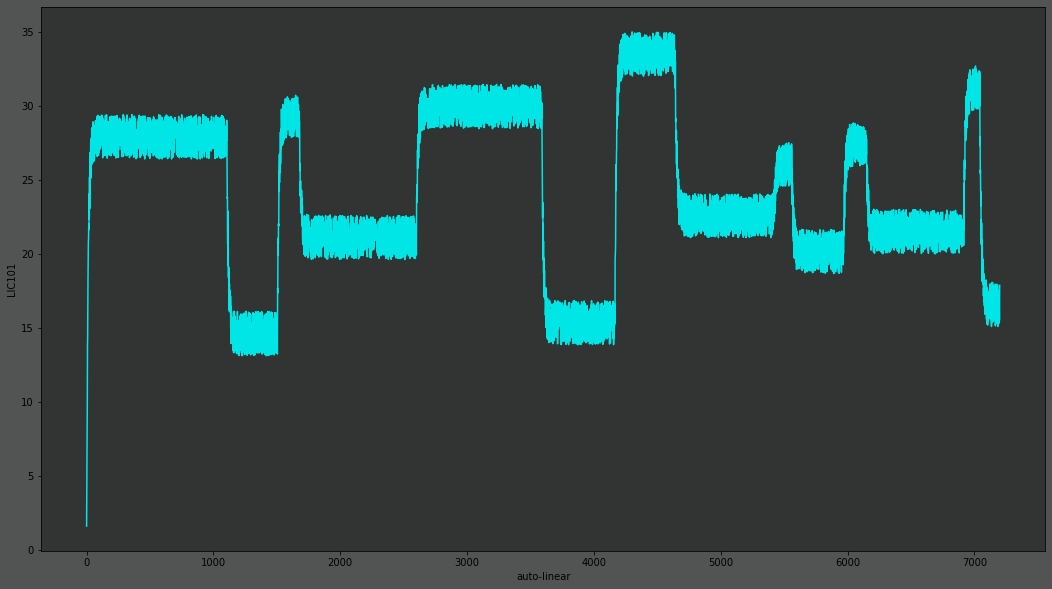

In [4]:
# Buscando um perído com uma variável bem ruidosa :) - já interpoalada a cada segundo
bv_LIC101 = epmConn.getDataObjects(['LIC101'])['LIC101']
# Valores "devem" ser informados em conforemidade com o Timezone ou em UTC (Coordinated Universal Time)
ini_date = datetime.datetime(2014, 3, 4, 2, tzinfo=pytz.utc)
end_date = datetime.datetime(2014, 3, 4, 4, tzinfo=pytz.utc)
query_period = epm.QueryPeriod(ini_date, end_date)
process_interval = datetime.timedelta(seconds=1)
# Dica: usar TAB após "epm.AggregateType." para ver métodos disponíveis (intelisense)
aggregate_details = epm.AggregateDetails(process_interval, epm.AggregateType.Interpolative)
try:
    data = bv_LIC101.historyReadAggregate(aggregate_details, query_period)
    plt.plot(data['Value'], color='#00e6e6') # plot apenas dos dados
    plt.xlabel("auto-linear")
    plt.ylabel(bv_LIC101.name)
    fig = plt.gcf()
    ax = plt.gca()
    fig.set_size_inches(18, 10)
    fig.patch.set_facecolor('#525454')
    ax.set_facecolor('#323434')
except Exception as exception:
    print(exception.__class__.__name__ + ': ' + exception.message)

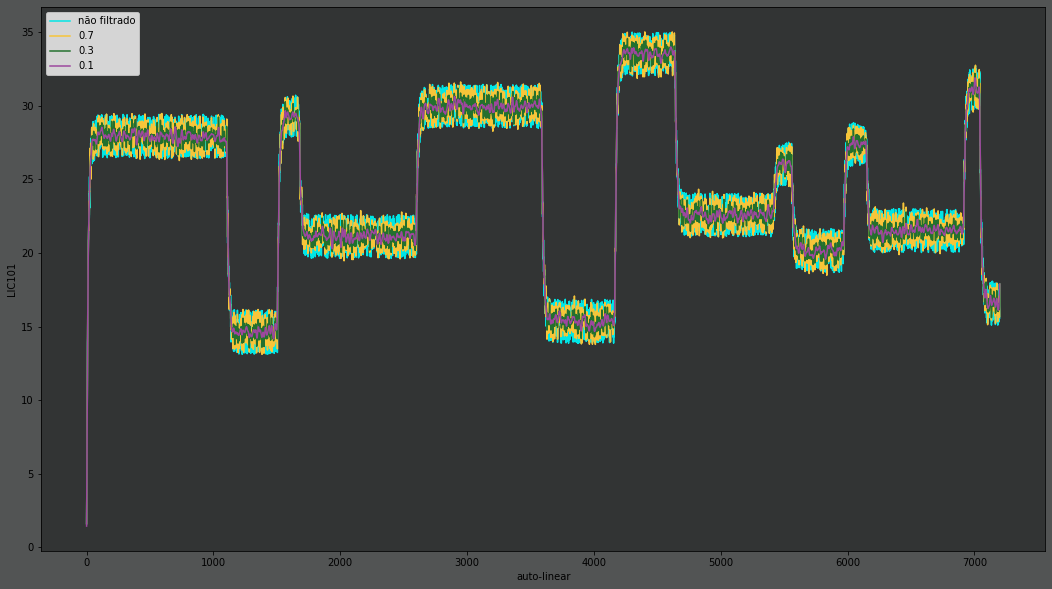

In [5]:
# Aplicando 3 filtros com frequências diferentes para ver o efeito da definição correta da mesma
cut_off_list = [0.7, 0.3, 0.1] # N vezes a frequência de Nyquist
color_list = ['#f7c539', '#23702e', '#9d479e']
order = 2
yf = []
for wn in cut_off_list:
    b, a = signal.butter(order, wn)
    yf.append(signal.filtfilt(b, a, data['Value']))
plt.plot(data['Value'], color='#00e6e6') # plot apenas dos dados
c = 0
for y in yf:
    plt.plot(y, color=color_list[c]) # plot dos valores filtrados
    c += 1
plt.xlabel("auto-linear")
plt.ylabel(bv_LIC101.name)
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax.set_facecolor('#323434')
legend = ['não filtrado'] + list(map(str, cut_off_list)) # Transforma lista de num. em de Strings
ax.legend(legend)

# Diferenciando o sinal - deixando dados estacionários

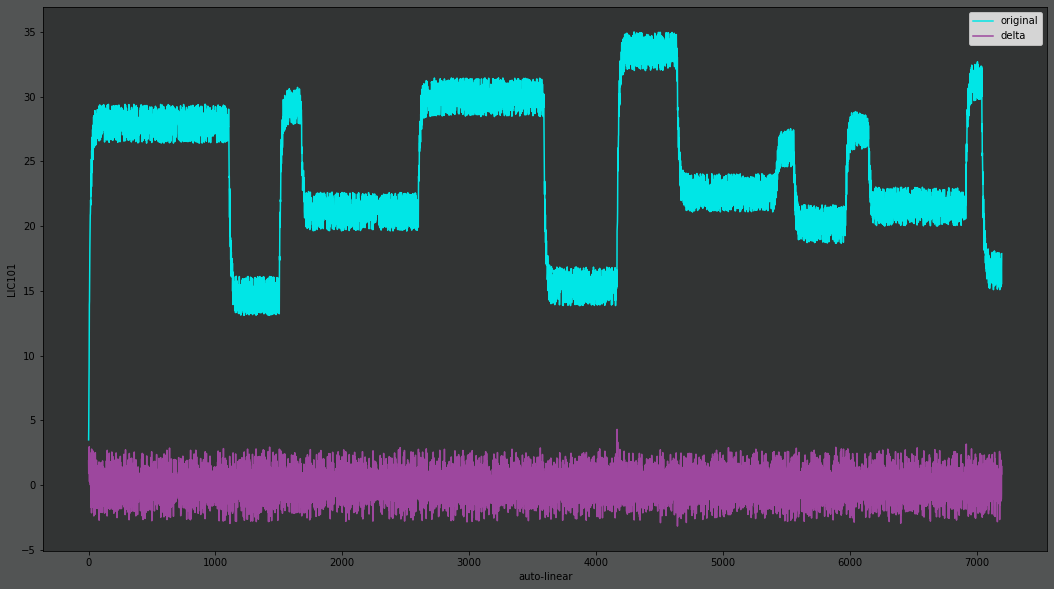

In [6]:
# Uma abordagem simples é aplicar um delta simples (faz um shift unitário dos dados e subtrai)
delta = data['Value'][1:] - data['Value'][:-1]
t = np.arange(len(delta))
plt.plot(t, data['Value'][1:], color='#00e6e6') # plot dos dados originais
plt.plot(t, delta, color='#9d479e') # plot do delta
plt.xlabel("auto-linear")
plt.ylabel(bv_LIC101.name)
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax.set_facecolor('#323434')
ax.legend(['original', 'delta'])

# Quantificando a "estacionaridade" :)

#### Existem diversas formas de definir se um sinal é ou não estacionário (além da visual :) ), mas, de maneira mais simples, pode-se dizer que um sinal é estacionário se a sua média e variância não se alteram ao longo do tempo - além de outras propriedades.
* Uma das formas mais usuais de verificar se um sinal é estacionário ou não, é através de um teste de hipótese chamado de *Augmented Dickey-Fulle* ([statsmodels.tsa.stattools.adfuller](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html));
* Objetivamente:
    * $H_0$: série temporal não é estacionária $\rightarrow$ para 5% $\rightarrow$ $pvalue > 0.05$
    * $H_1$: série temporal é estacionária     $\rightarrow$ para 5% $\rightarrow$ $pvalue \leq 0.05$

In [7]:
# Dados sem aplicação do delta
r1 = adfuller(data['Value'][1:])
print('ADF Statistic: %f' % r1[0])
print('p-value: %f' % r1[1])
print('Critical Values:')
for key, value in r1[4].items():
	print('\t%s: %.3f' % (key, value))
# Dados com a aplicação do delta
r2 = adfuller(delta)
print('ADF Statistic: %f' % r2[0])
print('p-value: %f' % r2[1])
print('Critical Values:')
for key, value in r2[4].items():
	print('\t%s: %.3f' % (key, value))

# ADF_1 -4 é menor que -3 (a 5 %) , isso sugere que podemos rejeitar H0, ou seja, sinal é estacionário!
# ADF_2 -15 é MUITO menor que -3.4 (a 1 %) , isso sugere que podemos rejeitar H0, ou seja, sinal é estacionário!

ADF Statistic: -3.833713
p-value: 0.002581
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistic: -15.388304
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


# Remoção de tendências (não é magia... :) )

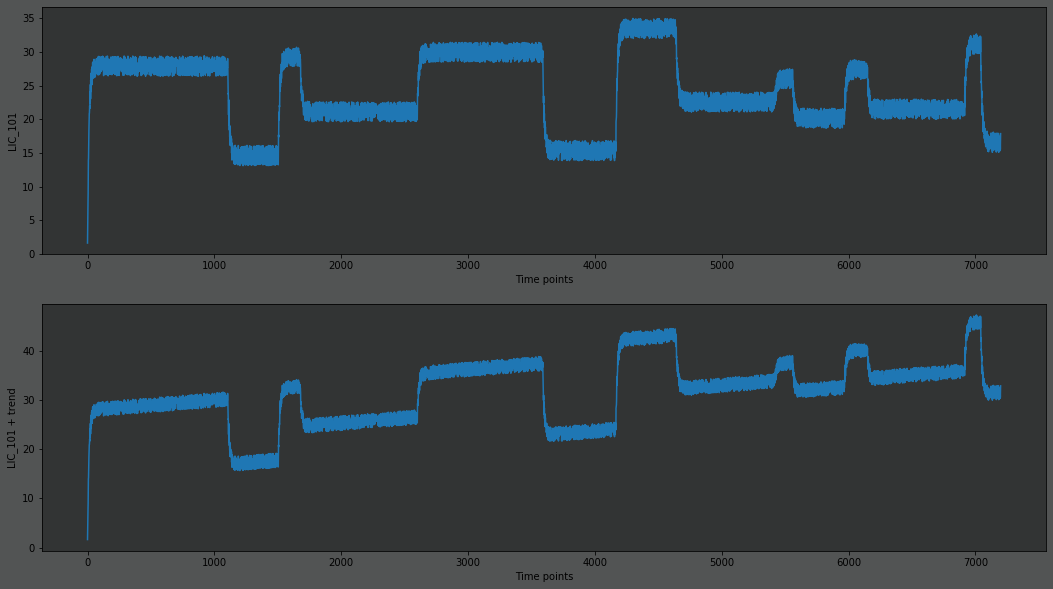

In [8]:
# Suponde a adição de uma constante no nosso sinal original
n = len(data['Value'])
t = np.arange(n)
y_with_trend = data['Value'] + 3 * np.linspace(0, 5, n) # Adicionando uma tendência linear positiva
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, data['Value'])
ax[0].set_xlabel('Time points')
ax[0].set_ylabel('LIC_101')
ax[1].plot(t, y_with_trend)
ax[1].set_xlabel('Time points')
ax[1].set_ylabel('LIC_101 + trend')
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax[0].set_facecolor('#323434')
ax[1].set_facecolor('#323434')

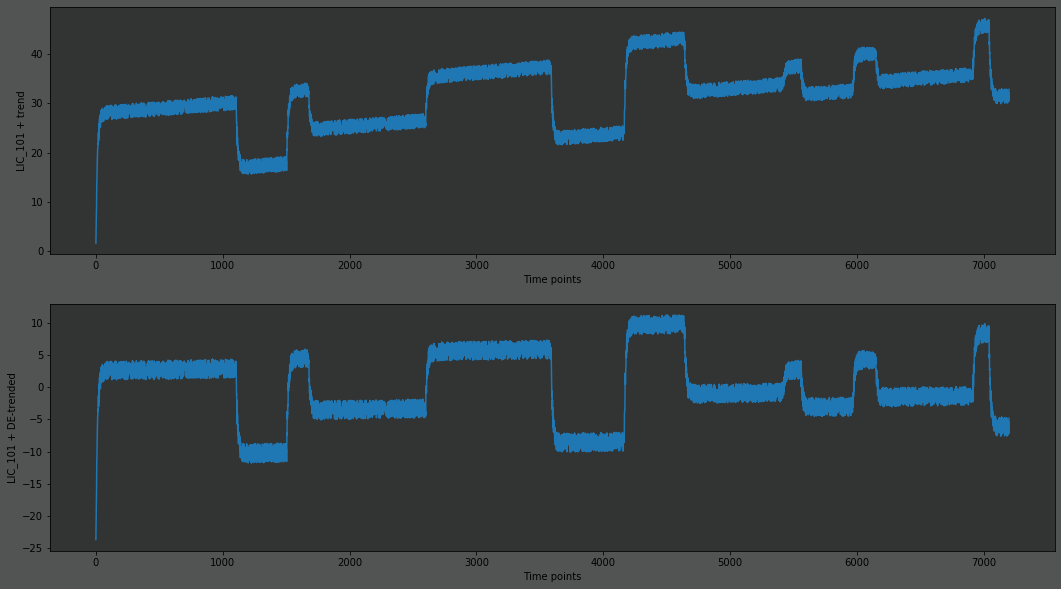

In [9]:
# Removendo a tendência adicionada
y_dtr = signal.detrend(y_with_trend, type='linear')
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, y_with_trend)
ax[0].set_xlabel('Time points')
ax[0].set_ylabel('LIC_101 + trend')
ax[1].plot(t, y_dtr)
ax[1].set_xlabel('Time points')
ax[1].set_ylabel('LIC_101 + DE-trended')
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax[0].set_facecolor('#323434')
ax[1].set_facecolor('#323434')

# Identificação do sistema por uma função de 1ª ordem

#### "Cara" da equação de Primeira ordem

$\tau \frac{\mathrm{d} y(t)}{\mathrm{d} t} + y(t) = k u(t)$

$k$: ganho do processo  $(\frac{\Delta y}{\Delta u})$

$\tau$ : constante de tempo do processo (tempo correspondente a apoximadamente 63% $\Delta y$)

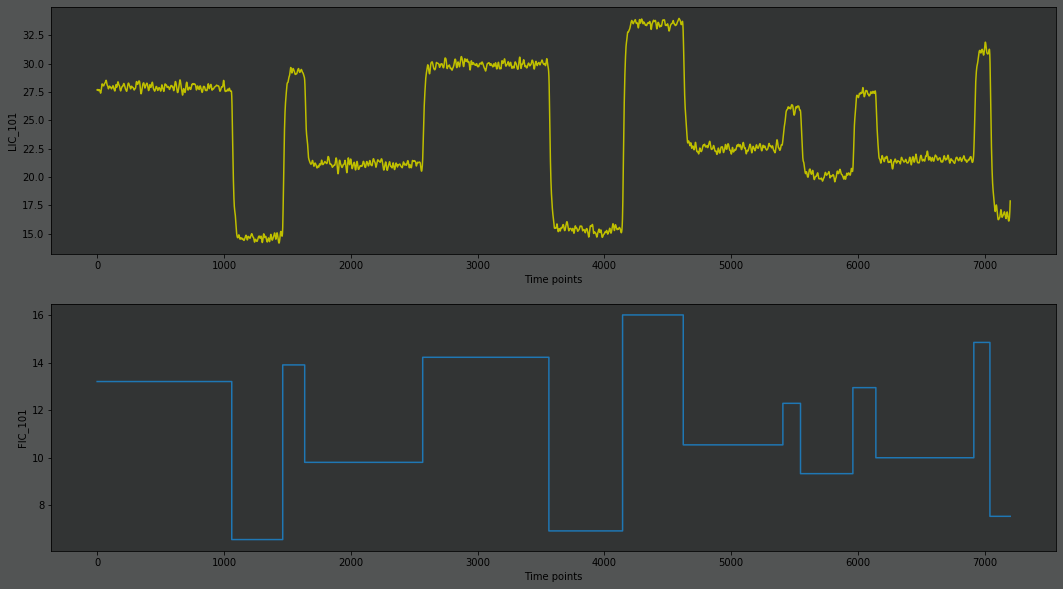

In [10]:
# BUSCANDO OS DADOS da variável de entrada (OP ou u, como preferir :) )
ini_ss_pos = 50
y_meas = yf[2][ini_ss_pos:]
n = len(y_meas)
t = np.linspace(0,7200,n) # create time vector
# u
bv_FIC101 = epmConn.getDataObjects(['FIC101'])['FIC101']
try:
    u = bv_FIC101.historyReadAggregate(aggregate_details, query_period)
    u_meas = u['Value'][ini_ss_pos:]
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(t, y_meas, 'y')
    ax[0].set_xlabel('Time points')
    ax[0].set_ylabel('LIC_101')
    ax[1].step(t, u_meas)
    ax[1].set_xlabel('Time points')
    ax[1].set_ylabel('FIC_101')
    fig.set_size_inches(18, 10)
    fig.patch.set_facecolor('#525454')
    ax[0].set_facecolor('#323434')
    ax[1].set_facecolor('#323434')
except Exception as exception:
    print(exception.__class__.__name__ + ': ' + exception.message)

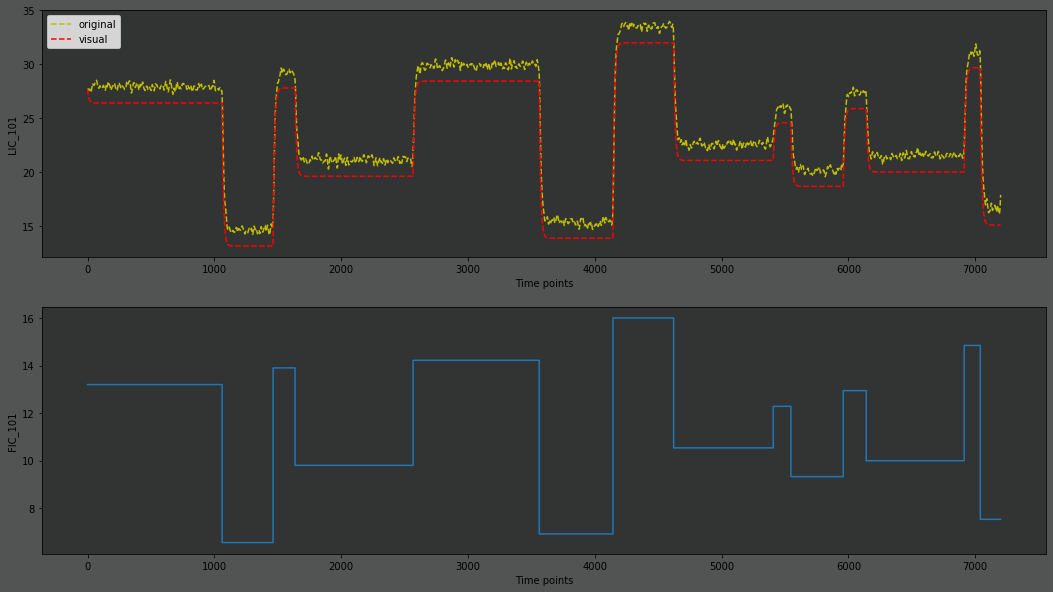

In [11]:
# Usnado o GEKKO para simular um modelo de primeira ordem com tempo morto
# Alternativamente poderia utilizar o módulo SciPy!
m = GEKKO()
m.time = t
# Modelo para simulação dinânica
m.options.IMODE = 4 # simulação dinâmica
# 1 - Steady-state simulation (SS)
# 2 - Model parameter update (MPU)
# 3 - Real-time optimization (RTO)
# 4 - Dynamic simulation (SIM)
# 5 - Moving horizon estiomation (EST)
# 6 - Nonlinear control / dynamic optimization (CTL)
# 7 - Sequential dynamic simulation (SQS)
# 8 - Sequential dynamic estimation (SQE)
# 9 - Sequential dynamic optimization (SQO)
#
k = 2.0    # visualmente estima Delta_y / Delta_u
tau = 10.0 # viasualmente estima em 10s
pv = m.Var(value=y_meas[0])
op = m.Param(value=u_meas)
m.Equation(tau*pv.dt()+pv==k*op) # Equação diferencial de primeira ordem
m.solve(disp=False)
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, y_meas, 'y--')
ax[0].plot(m.time, pv.value, 'r--')
ax[0].set_xlabel('Time points')
ax[0].set_ylabel('LIC_101')
ax[1].step(m.time, op.value)
ax[1].set_xlabel('Time points')
ax[1].set_ylabel('FIC_101')
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax[0].set_facecolor('#323434')
ax[1].set_facecolor('#323434')
ax[0].legend(['original', 'visual'])

In [13]:
# Utilizando o GEKKO para estimar os parâmetros k e tau
# Alternativamente poderia utilizar o ScyPy-Optimization-Minimization!
mo = GEKKO()
mo.options.IMODE = 2 # Estimativa de parâmetros
k_est = mo.FV(value=1.0, lb=1.0, ub=10.0)   # Ganho do processo  - FV: Fixed Values por um horizonte de temp o
k_est.STATUS = 1 # Ativa o status da variável a ser otimizada (indica que é para otimizar)
tau_est = mo.FV(value=5.0, lb=0.1, ub=100.0) # Constante de tempo
tau_est.STATUS = 1 # Ativa o status da variável a ser otimizada
y_m = mo.Param(value=y_meas)
u_m = mo.Param(value=u_meas)
y_p = mo.Var(value=y_meas[0])
mo.Equation(tau_est*y_p.dt()+y_p==k_est*u_m) # Equação diferencial de primeira ordem
#mo.Obj(((y_p-y_m)/y_m)**2) # Função objetivo - normalizando deu um ganho menor, porém mais rápido
mo.Obj(((y_p-y_m))**2) # Função objetivo
mo.solve(disp=False)
print(f'k estimated: {k_est.value[0]}')
print(f'tau estimated: {tau_est.value[0]}')

k estimated: 2.1219091946
tau estimated: 49.992472299


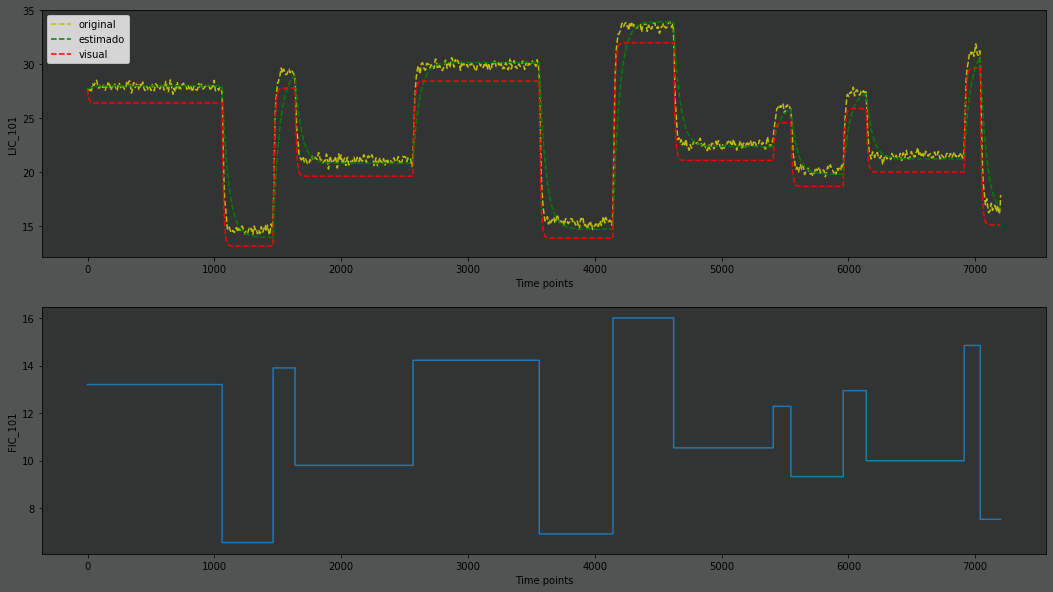

In [14]:
# Simulando com os novos parâmetros estimados
m2 = GEKKO()
m2.time = t
# Modelo para simulação dinânica
m2.options.IMODE = 4 # simulação dinâmica
k2 = k_est.value[0]
tau2 = tau_est.value[0] 
pv2 = m2.Var(value=y_meas[0])
op2 = m2.Param(value=u_meas)
m2.Equation(tau2*pv2.dt()+pv2==k2*op2) # Equação diferencial de primeira ordem
m2.solve(disp=False)
fig, ax = plt.subplots(2, 1)
ax[0].plot(m2.time, y_meas, 'y--')
ax[0].plot(m2.time, pv2.value, 'g--')
ax[0].plot(m.time, pv.value, 'r--')
ax[0].set_xlabel('Time points')
ax[0].set_ylabel('LIC_101')
ax[1].step(m2.time, op2.value)
ax[1].set_xlabel('Time points')
ax[1].set_ylabel('FIC_101')
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax[0].set_facecolor('#323434')
ax[1].set_facecolor('#323434')
ax[0].legend(['original', 'estimado', 'visual'])

# Enfim... PANDAS!!!

* ref.1: [GitHub/Elipse Software/ basic_use_pandas.ipynb ](https://nbviewer.jupyter.org/github/elipsesoftware/epmwebapi/blob/master/exemplos/basic_use_pandas.ipynb)
* ref.2: [EPM para analistas de dados: análises preliminares utilizando o módulo pandas da linguagem Python - min: 6:09](https://youtu.be/DPrZv80fOuw?t=369)

In [3]:
# BUSCANDO OS DADOS de Agosto, Setembro e Outubro/2016 (3 meses) de um Aerogerador (pot. 2KW)
wind_speed = epmConn.getDataObjects(['Aero01_Wind_speed'])['Aero01_Wind_speed']
wind_direction = epmConn.getDataObjects(['Aero01_Wind_direction'])['Aero01_Wind_direction']
active_power = epmConn.getDataObjects(['Aero01_Active_power'])['Aero01_Active_power']
ini_date = datetime.datetime(2016, 8, 1, 3, tzinfo=pytz.utc) # local-time: 2016-08-01 00:00:00
end_date = datetime.datetime(2016, 11, 1, 3, tzinfo=pytz.utc) # local-time: 2016-11-01 00:00:00
query_period = epm.QueryPeriod(ini_date, end_date)
process_interval = datetime.timedelta(minutes=10)
# Dica: usar TAB após "epm.AggregateType." para ver métodos disponíveis (intelisense)
aggregate_details = epm.AggregateDetails(process_interval, epm.AggregateType.TimeAverage)
try:
    bv_list = [wind_speed, wind_direction, active_power]
    data = [bv.historyReadAggregate(aggregate_details, query_period) for bv in bv_list]
    timestamp = data[0]["Timestamp"]
    print(f'Primeiro timestamp está em UTC: {timestamp[0]}')
except Exception as exception:
    print(exception.__class__.__name__ + ': ' + exception.message)

Primeiro timestamp está em UTC: 2016-08-01 03:00:00+00:00


In [4]:
# Convertendo para a data-hora Local (America/Sao_Paulo)
# tz_sp = pytz.timezone('America/Sao_Paulo') - prece haver um problema com o timezone 'America/Sao_Paulo' (6 min)
tz = datetime.timezone(datetime.timedelta(hours=-3)) # Desta forma se utiliza explicitamente o Off-set!
def utc2tz(dt, tz):
    """ Converte date-time em UTC para timezone informada - removendo tzinfo
    """
    return dt.astimezone(tz).replace(tzinfo=None)

local_timestamp = list(map(utc2tz, timestamp, [tz]*len(timestamp)))
print(f'Primeiro timestamp em hora local: {local_timestamp[0]}')

Primeiro timestamp em hora local: 2016-08-01 00:00:00


In [5]:
# Definição de uma função que organiza os dados de Séries Temporais do EPM em um Dataframe do Pandas
def epm2pandas(timestamp_index=None, **kwargs):
    # É necessário que todos tenham o mesmo timestamp para usar como index
    # ex: df = epm2pandas(var1=epmDataVar1, var2=epmDataVar2, var3=epmDataVar3) # pode ter qtas variáveis quiser! :)
    df = None
    def newByteOrderAndVectorize(epm):
        # Reordena os bytes para o pandas funcionar corretamente numpay array do EPM
        v = epm['Value'].byteswap().newbyteorder()
        return v.reshape(len(v),1)

    if len(kwargs)>0:
        columnNames = []
        notFirst = False
        for key, value in kwargs.items():
            columnNames.append(key)
            if notFirst:
                v = newByteOrderAndVectorize(value)
                data = np.hstack((data, v))
            else: # primeira coluna de timestamp é utilizada para todos as demais variáveis
                notFirst = True
                data = newByteOrderAndVectorize(value)
                if timestamp_index is None:
                    timestamp_index = value['Timestamp']
        df = pd.DataFrame(data, index=timestamp_index, columns = columnNames)
    return df

In [6]:
# Montando um Dataframe com os dados lidos nas 3 consulta de média ponderado ao longo do tempo a cada 10 min
df = epm2pandas(timestamp_index=local_timestamp, speed=data[0], direction=data[1], power=data[2])
df.info() # informações do Dataframe

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13248 entries, 2016-08-01 00:00:00 to 2016-10-31 23:50:00
Data columns (total 3 columns):
speed        13248 non-null float32
direction    13248 non-null float32
power        13248 non-null float32
dtypes: float32(3)
memory usage: 258.8 KB


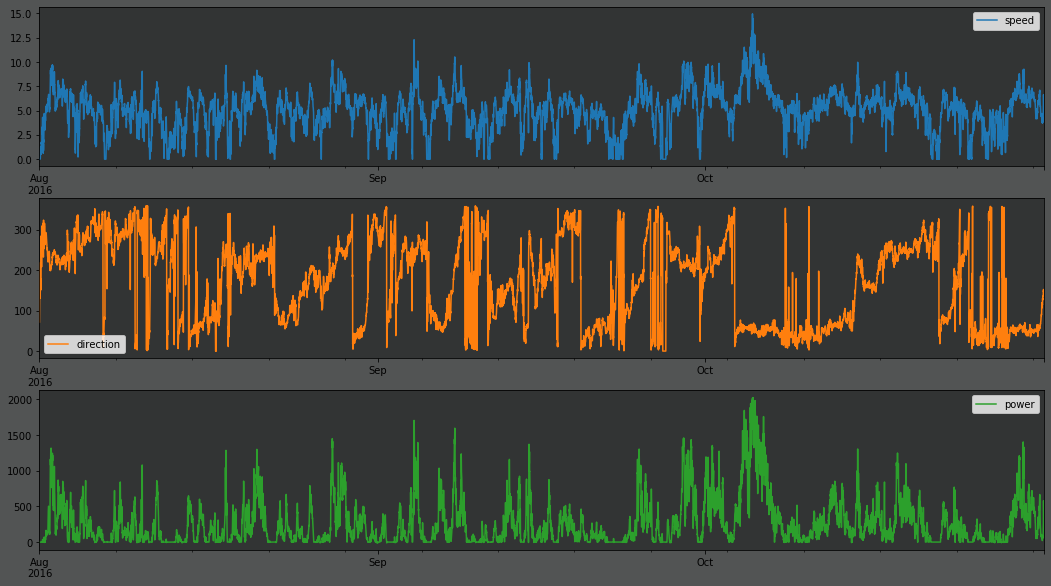

In [19]:
# Obtendo informações (visão geral) sobre os dados
df.describe() # Estatísticas dos dados
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 10))
df.plot(subplots=True, ax=axes) # Plota tudo, com suporte a Sub-plots! :)
fig.patch.set_facecolor('#525454')
for ax in axes:
    ax.set_facecolor('#323434')

#### Analisar estas 3 variáveis em um gráfico de tendências, não "diz" muita coisa...

#### O ideal é sempre buscar a melhor alternativa gráfica para expor de maneira mais clara as informações desejadas.

#### Neste caso em particular, o ideal é um Polar Chart (gráfico polar)

#### Para complicar - vamos "precisamos apenas" ver os dados do MÊS de Setembro!

In [7]:
# Aplicando um filtro para pegar apenas os dados do mês de setembro
data_sep = df[(df.index > datetime.datetime(2016, 9, 1)) & (df.index < datetime.datetime(2016, 10, 1))]
print('HEAD')
print(data_sep.head())
print(10 * '-')
print('TAIL')
print(data_sep.tail())

HEAD
                     speed   direction  power
2016-09-01 00:10:00  2.515  285.244995 -0.065
2016-09-01 00:20:00  2.655  284.895020 -0.070
2016-09-01 00:30:00  2.615  284.165009 -0.070
2016-09-01 00:40:00  2.550  282.835022 -0.065
2016-09-01 00:50:00  2.630  281.705017 -0.070
----------
TAIL
                     speed   direction       power
2016-09-30 23:10:00  8.285  190.514999  898.084961
2016-09-30 23:20:00  7.425  188.160004  681.674988
2016-09-30 23:30:00  7.120  183.980011  547.835022
2016-09-30 23:40:00  7.815  182.184998  692.940002
2016-09-30 23:50:00  8.040  185.699997  770.119995


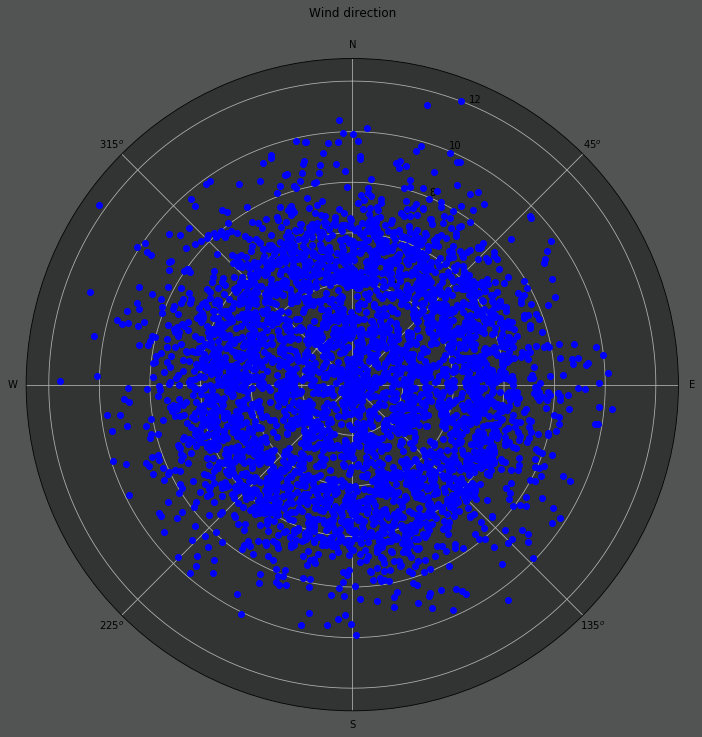

In [8]:
ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.grid(True)
ax.xaxis.set_ticklabels(['N',r"$45^{o}$",'E',r"$135^{o}$",'S',r"$225^{o}$",'W', r"$315^{o}$"])
ax.set_title("Wind direction", va='bottom')
ax.plot(data_sep.direction, data_sep.speed, 'bo')
fig = plt.gcf()
fig.set_size_inches(12, 12)
fig.patch.set_facecolor('#525454')
ax.set_facecolor('#323434')

#### Vamos supor que os Aerogeradores "SÓ OPERAM" nos días úteis :)

#### "Preciso" ver as mesmas informações acima só que apenas dos dias úteis e adicionando também a potência ativa produzida!

In [9]:
# Pegando apenas os dias úteis do mês de setembro (Seguda à Sexta-feira)
data_busines_day = data_sep[data_sep.index.dayofweek < 5] # Seg=0, Ter=1...Sab=5, Dom=6,
print(f'Quantidade de dados do mês se setembro: {len(data_sep)}')
print(f'Quantidade de dados dos DIAS ÚTEIS do mês se setembro: {len(data_busines_day)}')

Quantidade de dados do mês se setembro: 4319
Quantidade de dados dos DIAS ÚTEIS do mês se setembro: 3167


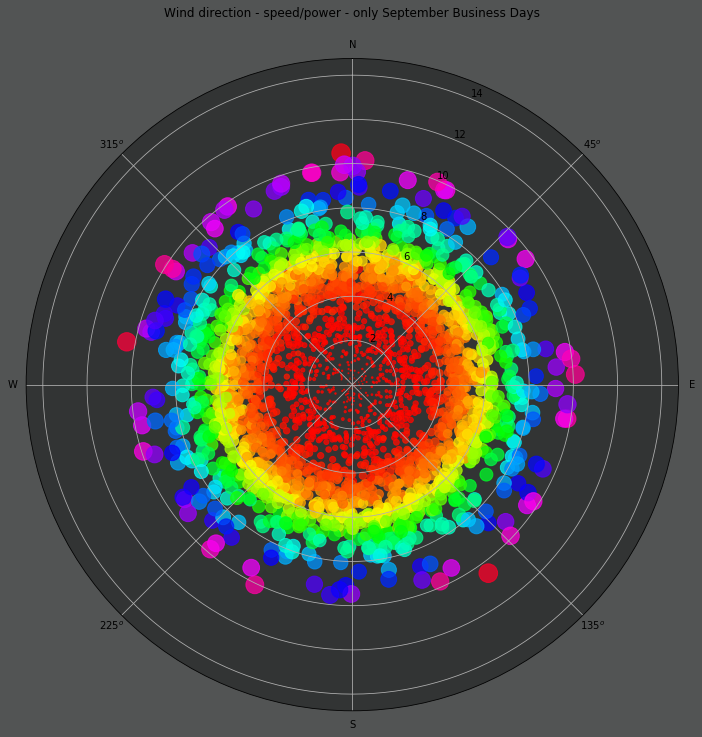

In [11]:
colors = data_busines_day.power/1000.0
area = np.pi * data_busines_day.speed**2
ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.grid(True)
ax.xaxis.set_ticklabels(['N',r"$45^{o}$",'E',r"$135^{o}$",'S',r"$225^{o}$",'W', r"$315^{o}$"])
c = plt.scatter(data_busines_day.direction, \
                data_busines_day.speed,\
                c=colors, s=area, cmap=plt.cm.hsv)
c.set_alpha(0.75)
ax.set_title("Wind direction - speed/power - only September Business Days", va='bottom')
#ax.plot(data_sep.direction, data_sep.speed, 'bo')
fig = plt.gcf()
fig.set_size_inches(12, 12)
fig.patch.set_facecolor('#525454')
ax.set_facecolor('#323434')

#### Bom mesmo este tal "Pandas" - já que agora eu tenho os dados apenas dos dias úteis do mês de setembro - como eu faço para levar para "outras ferramentas mais trabalhosas"?! :)
* Dica: salvar em .CSV, .HDF5....

In [24]:
# Salvando em um arquivo .CSV
data_busines_day.to_csv(r'c:\temp\Sep_data_busines_day.csv', header=True)
print('Confere se está lá mesmo!!! :)')

Confere se está lá mesmo!!! :)


# Análise no domínio da frequência

#### Dica para compreender melhor as análises no domínio da frequência
* [excelente animação - domínio da frequência](https://youtu.be/r18Gi8lSkfM)
* [SciPy 2017: Fast Template Periodogram for Finding Periodic Non Sinusoidal Waveforms in Noisy, Irregularly Samp](https://youtu.be/7STeeVnfYFM)
* [exemplo prático 1:A comparative study between seasonal wind speed by Fourier and Wavelet analysis](https://www.researchgate.net/profile/Debadatta_Dash2/publication/264425136_A_comparative_study_between_seasonal_wind_speed_by_Fourier_and_Wavelet_analysis/links/5b8bc3f892851c1e12425f68/A-comparative-study-between-seasonal-wind-speed-by-Fourier-and-Wavelet-analysis.pdf)
* [exemplo prático 2: Advanced Signal Processing Techniques for FaultDetection and Diagnosis in a Wind Turbine InductionGenerator Drive Train: A Comparative Study](https://hal.archives-ouvertes.fr/hal-00532625/document)

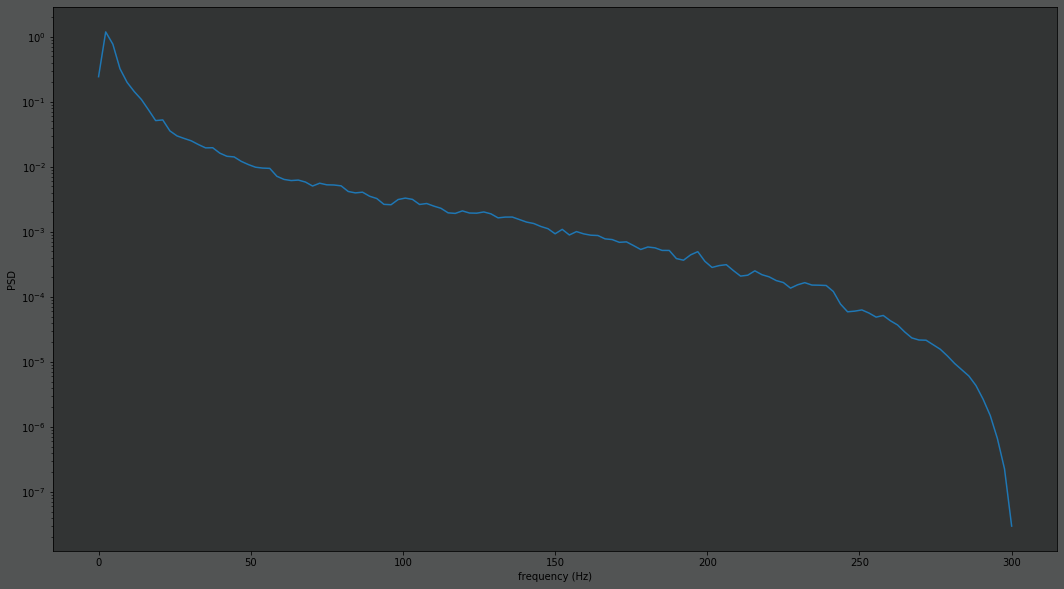

In [25]:
# PERIODIGRAM - PSD (Power Spectral Density)
# Auxilia na captura da frequência do processo estocástico e identifica periodicidades

# Para o caso particular de análise do espectro para vento, ver artigo:
# How to calculate wind spectra: https://www.nwpsaf.eu/publications/tech_reports/nwpsaf-kn-tr-008.pdf

# Analizando os dados dos 3 meses da velocidade do vento
data_speed = df.speed.to_numpy()
fs = 10.0 * 60;  # frequencia de amostragem em segundos
n = len(data_speed)
t = np.arange(n) / fs
# An improved method, especially with respect to noise immunity, is Welch’s method!
f, Pper_spec = signal.welch(data_speed, fs, scaling='spectrum')
fig, ax = plt.subplots()
ax.semilogy(f, Pper_spec) # plot do espectro
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('PSD')
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax.set_facecolor('#323434')

# Decompondo um sinal

### Uma Série Temporal (sinal) pode ser decomposta da seguinte forma

$Y_t = f(T_t, C_t, S_t, \varepsilon_t)$

onde:
* $Y_t$: série temporal
* $T_t$: componente relacionada à tendência
* $C_t$: compenente relacionada aos ciclos
* $S_t$: componente relacionada à sasonalidades
* $\varepsilon_t$: componente relacionáda aos ruídos (todos demais erros)

Referências:
* ref.1:[Análise de Séries Temporais](http://w3.ufsm.br/jpa/CCeTI/S%E9ries%20temporais.pdf)
* ref.2: [Aprendendo Decomposição Clássica: Tutorial para um Método de Análise de Séries Temporais](http://www.anpad.org.br/periodicos/arq_pdf/a_1320.pdf)

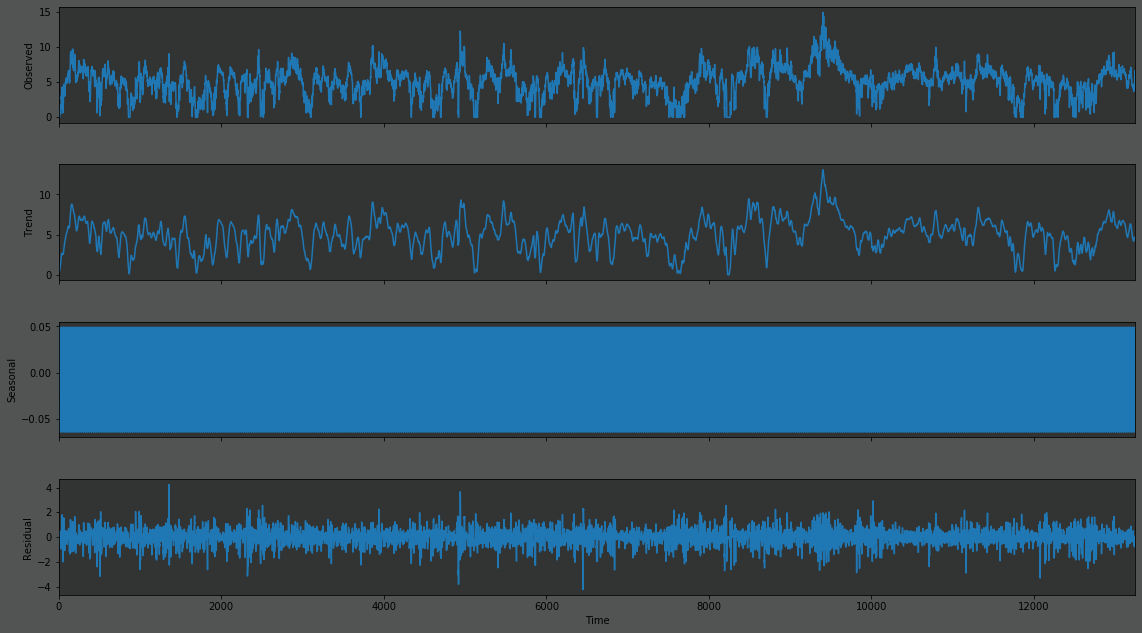

In [26]:
decomp = seasonal.seasonal_decompose(data_speed, freq=24, model='additive') # ou 'multiplicative'
# ref.: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
#       freq: Frequency of the series. Must be used if x is not a pandas object
fig = decomp.plot()
#axs = plt.get_axes()
axs = fig.get_axes()
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
for ax in axs:
    ax.set_facecolor('#323434')

# Modelo ARIMA - Autoregressive Integrated Moving Average

#### REFERÊNCIAS

* ref.1:[SARIMAX: Introduction](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)
* ref.2: [A Gentle Introduction to SARIMA for Time Series Forecasting in Python](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)
* ref.3: [An End-to-End Project on Time Series Analysis and Forecasting with Python](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)

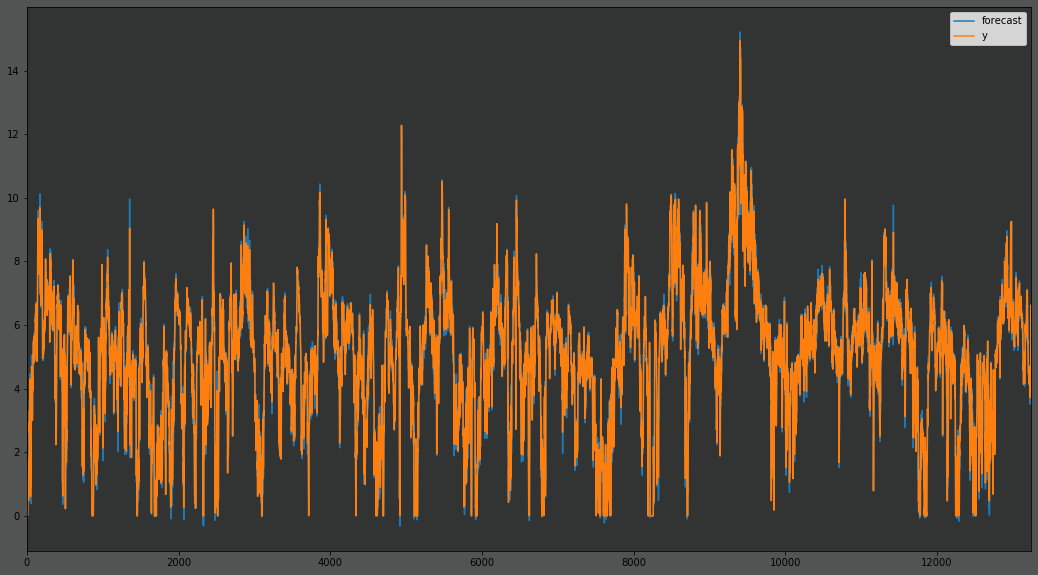

In [27]:
mod = sm.tsa.arima_model.ARIMA(data_speed, order=(2, 2, 1))
results = mod.fit()
fig = results.plot_predict()
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
for ax in fig.get_axes():
    ax.set_facecolor('#323434')

#### É ALTAMENTE RECOMENDADO SEMPRE encerrar a sessão previamente criada !!!

* ao encerrar a sessão, a conexão de *EPM Client* que estava sendo contabilizada na *Hard Key (HK)* é liberada para que outro usuário possa fazer uso dela;
* a sessão tem um *Time out* de 5 minutos - se o processo Python "cair", a sessão será liberada automaticamente após transcorrido este tempo;

In [12]:
# SEMPRE deve-se encerrar a conexão estabelecida com o EPM Server, pois isso irá encerrar a sessão e
# liberar a licença de EPM Client para que outros, eventualmente, possam utilizá-la.
epmConn.close()

#### DICAS

[Exemplos no GitHub da Elipse Software](https://nbviewer.jupyter.org/github/elipsesoftware/epmwebapi/tree/master/exemplos/)

[EPM para analistas de dados: análises preliminares utilizando o módulo pandas da linguagem Python](https://youtu.be/DPrZv80fOuw)

[Webinar - Agilizando análises no EPM com o poder da linguagem Python](https://youtu.be/1u9z6YD_2P0)

[Webinar - Análise de Dados com Python e Dashboard Web](https://youtu.be/IYg5yutkIhw)

[Exemplos MSP no Anaconda Cloud](https://anaconda.org/mauricioposser)

## _FIM do bônus ..._

#### Retornar à apresentação